# Algorithms for determinig cluster order picking strategies

This notebook explains and demonstrates the algorithms for finding strategies for "Cluster Order Picking" proposed by Goetschalckx and Ratliff (1988)

## Imports

In [1]:
import time
from datetime import datetime
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import Random

## Beschreibung des Problems

### Ziel
Minimierung der Komissionierdauer für die gesamte Bestellung (picking-time)

### Parameter
- a) round-trip-walking-time
- b) time-to-start-stop ($f$)
- c) driving time (independent from stops)
- d) time to pick items (independent from stops)
- e) time to stack items (independent from stops)
- distance from beginning of ailse to pick $i$: $a_{i}$
- distance from beginning of aisle to stop $j$: $z_{j}$
- width of aisle $A$
- distance between stop $j$ and pick $i$: $d_{ji }$ (Siehe Distanzmaße)
- number of items to be picked in aisle $N$
- Laufgeschwindigkeit des Kommissionierers zwischen Regalplatz und Komissionierfahrzeug: $v$
- total time per stop (roundtriptime to picks) $c_{j}=f+ 2 \sum_{i \in P_{j}} d_{ij}/v$

### Distanzmaße
Der Algorithmus kann mit zwei verschiedenen Distanzmaßen verwendet werden. Praktisch sind die Ergebnisse, die mit den beiden Distanzmaßen meist identisch oder weichen nur sehr gering voneinander ab. Für den Praktischen Einsatz wird deshalb *Rectilinear*, aufgrund der geringeren Laufzeit empfohlen. (Zitat)

#### Euclidean
Distanz von stop $j$ zu pick $i$ bei einer Gangbreite von $A$ nach *euklidischem* Abstand:

$$ d_{ij} = \sqrt{(a_{i}-z_{j})^2+ (A/2)^2} $$

In [2]:
def distance_euklidean(stop_position, pick_position, aisle_width):
    return sqrt((pick_position - stop_position)**2+(aisle_width/2)**2)

In [3]:
# Example:
distance_euklidean(3, 4, 7)

3.640054944640259

#### Rectilinear
Distanz von stop $j$ zu pick $i$ bei einer Gangbreite von $A$ nach *rectilinearem* Abstand:

$$ d_{ij} = |(a_{i}-z_{j})| + (A/2) $$

In [4]:
def distance_rectilinear(stop_position, pick_position, aisle_width):
    return abs(pick_position - stop_position) + aisle_width/2

In [5]:
# Example:
distance_rectilinear(3, 7, 4)

6.0

## Kostenfunktion
Da Ziel ist die Komissionierzeit zu minimieren, misst die Kostenkunktion die Dauer des Komissioniervorgangs.
Die Kosten $c_{j}$ für eine Menge zu pickender Items $P_{j}$ bei einem Stop $j$ sind gegeben durch:
$$ c_{j}=f+ 2 \sum_{i \in P_{j}} d_{ij}/v $$
wobei die Berechnung abhängig von der Wahl des Distanzmaßes ist.

In [6]:
def cost_measure(item_positions, stop_position, walking_speed, time_to_start_stop, aisle_width,
                 distance_measure):
    return time_to_start_stop + 2*sum([distance_measure(stop_position, i, aisle_width)/walking_speed for i in item_positions])

In [7]:
# Example
cost_measure([1,2,3,4], 2, 1, 2, 4, distance_euklidean)

20.60112615949154

## Optimale Stops
Algorithmus zur Bestimmung der Optimalen Stopstrategie bei frei positionierbaren stops
### Eigenschaften:
1. Items werden immer beim Stop mit der geringsten Entfernung aufgeladen.

2. Items picked at the same stop are in one line on both sides by the order which does not contain cases picked at other stops.
    - Blockstruktur: Alle Alle Items, die bei einem Stop aufgladen werden, liegen sind in einer ununterbrochenen Reihe (Block)

3. Optimale Halteposition $z_{j}$ bei einer vorgegebenen Menge von zu ladenden Items $P_{j}$ mit *euklidischem* Distanzmaß (Iterativer Prozess): ( the optimal stoplocation ($z_{j}$) for a given set of picks $(P_{j})$ under *euclidean* distannce (single facility *Euclidean* location problem) is determined by (iterative procedure):
$$z_{j}=\frac{ \sum_{i \in P_{j}} a_{i}/d_{ij} }{\sum_{i \in P_{j}} 1/d_{ij}}$$

In [8]:
def optimal_stop_euclidean(item_positions, aisle_width, starting_point=0, iterations=10):
    z = starting_point
    for _ in range(iterations):
        distances = [distance_euklidean(z, a, aisle_width) for a in item_positions]
        z = sum(a/d for (a,d) in zip(item_positions, distances)) / sum(1/d for d in distances)
    return z

In [9]:
# Example
optimal_stop_euclidean([2,5,7], 4)

4.834449438734148

4. Optimale Halteposition $z_{j}$ bei einer vorgegebenen Menge von zu ladenden Items $P_{j}$ (aufsteigend sortiert) mit *rectilinearem* Distanzmaß:
    - $|P_{j}|$ ungerade: Position des Items in der Mitte
    - $|P_{j}|$ ungerade: Alle Positionen zwischen den beiden Mittleren sind optimal (Implementierung wählt die Mitte)

In [10]:
def optimal_stop_rectilinear(item_positions, aisle_width):
    sorted = list(item_positions) # copy list
    length = len(sorted)
    sorted.sort()
    if length % 2:
        return sorted[int(length/2)]
    else:
        return (sorted[int(length/2)] + sorted[int(length/2) -1])/2

In [11]:
# Example
optimal_stop_rectilinear([2,5,7,100,1000], 4)

7

## Dynamische Programmierung
Implementierung, des Algorithmus

In [12]:
def optimal_stops(item_positions, aisle_width,
                  walking_speed,
                  time_to_start_stop,
                  distance_measure=distance_euklidean,
                  optimal_stop_func=optimal_stop_euclidean,
                  cost_measure=cost_measure,
                  **kwargs):
    """
    Calculates optimal number of stops and items picked per stop
    :returns: list containing the optimal item sets and the target value for the calculated solution
    """
    # Adding artificial first elemenmt
    sorted_items = [0] + list(item_positions)
    sorted_items.sort()
    
    # Adding artificial first element
    path_lengths = [float('inf')] * len(sorted_items)
    path_lengths[0] = 0
    optimal_predecessors = [0] * len(sorted_items)
    
    for index, item in enumerate(sorted_items[1:], 1):
        #print('Item: {} at index: {}'.format(item, index))
        for pred_index, pred_item in enumerate(sorted_items[:index]):
            #print(pred_item, pred_index)
            item_set = sorted_items[pred_index+1:index+1]
            optimal_location = optimal_stop_func(item_set, aisle_width=aisle_width)
            arc_length = cost_measure(
                item_set,
                stop_position=optimal_location,
                walking_speed=walking_speed,
                time_to_start_stop=time_to_start_stop,
                aisle_width=aisle_width,
                distance_measure=distance_measure
            )
            if path_lengths[index] > (path_lengths[pred_index] + arc_length):
                path_lengths[index] = path_lengths[pred_index] + arc_length
                optimal_predecessors[index] = pred_index
    
    target_value = path_lengths[-1]
    item_sets = list()
    index = len(optimal_predecessors) - 1
    while index > 0:
        pred_index = optimal_predecessors[index]
        item_sets.append(tuple(sorted_items[pred_index+1:index+1]))
        index = pred_index
    item_sets.reverse()
    return item_sets, target_value

In [13]:
# Example
item_positions = [2000,2000, 100, 2, 1, 3, 4,5,6,7]
optimal_stops(item_positions, aisle_width=2, walking_speed=10, time_to_start_stop=1)

([(1, 2, 3, 4, 5, 6, 7), (100,), (2000, 2000)], 6.525024734715915)

## Erweiterung um Fernsteuerung
Das Komissionierfahrzeug bietet zwei Möglichkeiten den nächsten Stop zu erreiche:
- Fahren: Der Kommissionierer besteigt das Fahrzeug und fährt zum nächsten Stop
- Rufen: Der Komissionierer läuft zum nächsten Stop, und löst über die Fernbedinung die Automatische Fahrt des Komissionierfahrzeugs zum Stop aus. Modelliert werden diese beiden zwei Arten von stops durch eine erweiterung der "**_time_to_start_stop_**:

**_time_to_start_stop_** wird funktional abhängig von folgenden parametern:
 - **_distance_between_stops_** zusammengesetzt aus:
     - vorheriger stop
     - aktueller stop
 - **_time_to_mount_unmount_**: Zeit, die bei der fahrt mit dem Komissionierfahrzeug anfällt (entspricht "originaler" **_time_to_start_stop_** )
 - **_walking_speed_**
 - **_time_to_call_**: Zeit, die für das "rufen" bzw. die Fernsteuerung des Komissionierfahrzeugs benötigt wird
 - **_remote_traveling_speed_**: Geschwindigkeit des Komissionierfahrzeugs wenn es sich ohne Fahrer bewegt
 - **_time_to_wait_**: Zeit, bis das ferngesteuerte Komissionierfahrzeug beim Komissionierer Eintrifft, zusamengesetzt aus:
     - **_distance_between_stops_**
     - **_remote_travelling_speed_**

Die **_time_to_start_stop_** ist immer das Minimum aus der **_time_to_mount_unmount_** (Komissionierer "fährt" zu nächstem stop) und der Zeit die es benötigt, zum nächsten stop zu laufen, dort das Fahrzeug zu rufen und dann auf die Ankunft zu warten.

In [14]:
def calculate_time_to_start_stop(last_stop, current_stop, time_to_mount, walking_speed, time_to_call, remote_travelling_speed):
    """
    returns a tuple with the first value beeing the calculated time and the second value beeing 1
    for a remote_controlled_stop and 0 for a driven halt
    """
    d = abs(last_stop - current_stop)
    walk_time = d / walking_speed
    call_time = d / remote_travelling_speed # time till cart arrives at the workers place if called
    calling = (walk_time + call_time + time_to_call)
    
    if calling < time_to_mount:
        # print('calling')
        return calling, 1
    else:
        # print('riding')
        return time_to_mount, 0
    
    
def modified_cost_measure(item_positions, stop_position, last_stop_position, walking_speed,
                          remote_travelling_speed, time_to_call, time_to_mount,
                          aisle_width, distance_measure, return_stop_type=False):
    """
    Calculates the cost for a stop
    additionally if return_type=True returns a tuple with the second value beeing 1
    for a remote_controlled_stop and 0 for a driven one
    """
    
    collecting_time = 2*sum([
        distance_measure(stop_position, i, aisle_width)/walking_speed for i in item_positions
    ])
    
    calculated_time, stop_type = calculate_time_to_start_stop(
            last_stop=last_stop_position,
            current_stop=stop_position,
            time_to_mount=time_to_mount,
            walking_speed=walking_speed,
            time_to_call=time_to_call,
            remote_travelling_speed=remote_travelling_speed
        )
    if return_stop_type:
        return calculated_time + collecting_time, stop_type
    else:
        return calculated_time + collecting_time

In [15]:
def modified_optimal_stops(item_positions, aisle_width,
                walking_speed,
                remote_travelling_speed,
                time_to_call,
                time_to_start_stop,
                distance_measure=distance_euklidean,
                optimal_stop_func=optimal_stop_euclidean,
                cost_measure=modified_cost_measure,
                **kwargs):
    """
    Calculates optimal number of stops and items picked per stop
    :returns: list containing the optimal item sets and the target value for the calculated solution
    """
    # Adding artificial first elemenmt
    sorted_items = [0] + list(item_positions)
    sorted_items.sort()
    
    # Adding artificial first element
    path_lengths = [float('inf')] * len(sorted_items)
    path_lengths[0] = 0
    optimal_predecessors = [0] * len(sorted_items)
    
    for index, item in enumerate(sorted_items[1:], 1):
        #print('Item: {} at index: {}'.format(item, index))
        for pred_index, pred_item in enumerate(sorted_items[:index]):
            #print(pred_item, pred_index)
            item_set = sorted_items[pred_index+1:index+1]
            optimal_location = optimal_stop_func(item_set, aisle_width=aisle_width)
            
            last_item_set = sorted_items[optimal_predecessors[pred_index]+1:pred_index+1]
            
            try:
                last_optimal_location = optimal_stop_func(last_item_set, aisle_width=aisle_width)
            except ZeroDivisionError:
                last_optimal_location = 0
                # print('item: {}, pred_item: {}, item_set: {}, last_item_set: {}'.format(
                #    index, pred_index, item_set, last_item_set
                #))
            
            
            arc_length = cost_measure(
                item_set,
                stop_position=optimal_location,
                last_stop_position=last_optimal_location,
                walking_speed=walking_speed,
                remote_travelling_speed=remote_travelling_speed,
                time_to_call=time_to_call,
                time_to_mount=time_to_start_stop,
                aisle_width=aisle_width,
                distance_measure=distance_measure
            )
            if path_lengths[index] > (path_lengths[pred_index] + arc_length):
                path_lengths[index] = path_lengths[pred_index] + arc_length
                optimal_predecessors[index] = pred_index
    
    target_value = path_lengths[-1]
    item_sets = list()
    index = len(optimal_predecessors) - 1
    while index > 0:
        pred_index = optimal_predecessors[index]
        item_sets.append(tuple(sorted_items[pred_index+1:index+1]))
        index = pred_index
    item_sets.reverse()
    return item_sets, target_value

In [16]:
# Example
item_positions = [2000,2000, 100, 2, 1, 3, 4,5,6,7]
modified_optimal_stops(item_positions, aisle_width=2,
                       walking_speed=10,
                       remote_travelling_speed=.001,
                       time_to_call=1000, time_to_start_stop=1)

([(1, 2, 3, 4, 5, 6, 7), (100,), (2000, 2000)], 6.525024734715915)

## Rechenstudie
### Parameter

In [17]:
def generate_item_positions(aisle_length, number_of_picks=None, random=Random('seed')):
    items = [random.uniform(0, aisle_length) for r in range(number_of_picks)]
    return items
        

In [18]:
# Example:
generate_item_positions(100, 10)

[13.823597922096532,
 23.670923666908305,
 86.50300528647699,
 28.626507136857025,
 4.325157940991986,
 96.57931468591995,
 72.60302506328844,
 60.76148550443735,
 52.839959055186135,
 65.8273349814433]

### Berechnung

In [19]:
aisle_length = 70 # Fiction: whole warehouse is a single long aisle
max_picks = 40


aisle_width = 3 #(3 Pallet locations)
walking_speed = 1.2
times_to_start_stop = (60, 30, 15, 7, 5)
times_to_call = (0, 1, 2.5, 5, 10)
remote_travelling_speeds = (1, 2, 5, 10, float('inf'))



In [20]:
def calc_distances(cluster_list, aisle_width, time_to_mount, walking_speed, time_to_call, remote_travelling_speed):
    """
    returns the optimal stop positions based on a given list of items to be comissioned at one stop
    """
    halting_points = []
    halting_points.append(optimal_stop_euclidean(cluster_list[0], aisle_width))
    distances = []
    
    for index, cluster in enumerate(cluster_list[1:], 1):
        halting_points.append(optimal_stop_euclidean(cluster, aisle_width))
        _, travel_type = calculate_time_to_start_stop(
            last_stop=halting_points[index-1],
            current_stop = halting_points[index],
            time_to_mount=time_to_mount,
            walking_speed=walking_speed,
            time_to_call=time_to_call,
            remote_travelling_speed=remote_travelling_speed
        )
        distances.append(
            (halting_points[index]-halting_points[index-1], travel_type)
        )
        
    return distances

In [21]:
# Example
calc_distances([(1, 2, 3, 4), (5, 6, 7), (100,), (2000, 2000)], 3, 60, 1.2, 0, 10)

[(3.500002730181031, 1), (94.00000003760425, 0), (1900.0, 0)]

In [28]:
seeds = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
comparisons = pd.DataFrame(columns=(
    'seed',
    'picks',
    'time_to_start_stop',
    'time_to_call',
    'remote_travelling_speed',
    'number_base_stops',
    'number_mod_stops',
    'number_remote_stops',
    'base_mean_distance',
    'mod_mean_distance',
    'base_cost',
    'mod_cost',
    'stops_difference',
    'cost_difference'
))
  

t0 = datetime.now()
for seed in seeds:
    random = Random(seed)
    
    for i in range(1, max_picks+1):
        
        item_positions = generate_item_positions(aisle_length, i, random=random)
        
        for t_to_start_stop in times_to_start_stop: 
            base_result = optimal_stops(
                item_positions, 
                aisle_width=aisle_width,
                walking_speed=walking_speed,
                time_to_start_stop=t_to_start_stop
            )
            for time_to_call in times_to_call:
                for remote_travelling_speed in remote_travelling_speeds:
                    mod_result = modified_optimal_stops(
                        item_positions,
                        aisle_width=aisle_width,
                        walking_speed=walking_speed,
                        time_to_start_stop=t_to_start_stop,
                        time_to_call=time_to_call,
                        remote_travelling_speed=remote_travelling_speed
                    )
                    base_distances, _ = ([0],[0]) if len(base_result[0]) <= 1 else \
                    zip(*calc_distances(
                        base_result[0],
                        aisle_width=aisle_width,
                        time_to_mount=t_to_start_stop,
                        walking_speed=walking_speed,
                        time_to_call=time_to_call,
                        remote_travelling_speed=remote_travelling_speed
                    )) 
                    mod_distances, mod_travel_types = ([0],[0])  if len(mod_result[0]) <= 1 else \
                    zip(*calc_distances(
                        mod_result[0],
                        aisle_width=aisle_width,
                        time_to_mount=t_to_start_stop,
                        walking_speed=walking_speed,
                        time_to_call=time_to_call,
                        remote_travelling_speed=remote_travelling_speed
                    ))
                    
                    comparisons = comparisons.append({
                        'number_remote_stops': np.sum(mod_travel_types),
                        'base_mean_distance': np.mean(base_distances),
                        'mod_mean_distance': np.mean(mod_distances),
                        'seed': seed,
                        'picks': i,
                        'time_to_start_stop': float(t_to_start_stop),
                        'time_to_call': float(time_to_call),
                        'remote_travelling_speed': float(remote_travelling_speed),
                        'number_base_stops': float(len(base_result[0])),
                        'number_mod_stops': float(len(mod_result[0])),
                        'base_cost': float(base_result[1]),
                        'mod_cost': float(mod_result[1]),
                        'stops_difference': float(len(mod_result[0]) - len(base_result[0])),
                        'cost_difference': float(mod_result[1] - base_result[1])
                    }, ignore_index=True)

comparisons.to_csv('comparisons-{}.csv'.format(comparisons.shape))
'Elapsed time: {}, Shape: {}'.format(str(datetime.now() - t0), comparisons.shape)

KeyboardInterrupt: 

### Auswertung
Angestellte Vergleiche:

In [22]:
comparisons = pd.read_csv('comparisons-(50000, 14).csv')
comparisons

,Unnamed: 0,seed,picks,time_to_start_stop,time_to_call,remote_travelling_speed,number_base_stops,number_mod_stops,number_remote_stops,base_mean_distance,mod_mean_distance,base_cost,mod_cost,stops_difference,cost_difference
0,0,1,1,60.0,0.0,1.0,1.0,1.0,0,0.000000,0.000000,62.500000,62.500000,0.0,0.000000
1,1,1,1,60.0,0.0,2.0,1.0,1.0,0,0.000000,0.000000,62.500000,47.136480,0.0,-15.363520
2,2,1,1,60.0,0.0,5.0,1.0,1.0,0,0.000000,0.000000,62.500000,37.093272,0.0,-25.406728
3,3,1,1,60.0,0.0,10.0,1.0,1.0,0,0.000000,0.000000,62.500000,33.745536,0.0,-28.754464
4,4,1,1,60.0,0.0,inf,1.0,1.0,0,0.000000,0.000000,62.500000,30.397800,0.0,-32.102200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,10,40,5.0,10.0,1.0,10.0,10.0,0,7.098033,7.098033,169.608962,169.608962,0.0,0.000000
49996,49996,10,40,5.0,10.0,2.0,10.0,10.0,0,7.098033,7.098033,169.608962,169.608962,0.0,0.000000
49997,49997,10,40,5.0,10.0,5.0,10.0,10.0,0,7.098033,7.098033,169.608962,169.608962,0.0,0.000000
49998,49998,10,40,5.0,10.0,10.0,10.0,10.0,0,7.098033,7.098033,169.608962,169.608962,0.0,0.000000


#### Anzahl der Stops
Vergleich des originalen mit dem Erweiterten Algorithmus

In [23]:
comparisons[['number_base_stops','number_mod_stops']].mean()

number_base_stops    5.38300
number_mod_stops     8.01942
dtype: float64

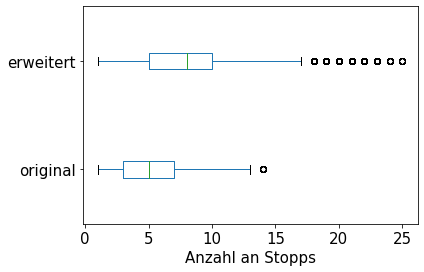

In [24]:
bp = pd.DataFrame(columns=('original', 'erweitert'))
bp['original'] = comparisons['number_base_stops']
bp['erweitert'] = comparisons['number_mod_stops']
p = bp.boxplot(
    rot=0,
    vert=False,
    grid=False,
    #figsize=(10, 5),
    fontsize=15,
)
p.set_xlabel('Anzahl an Stopps', fontsize=15)
p

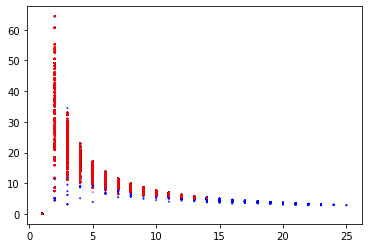

In [25]:
xs = pd.concat((comparisons['number_mod_stops'], comparisons['number_base_stops']), ignore_index=True)
ys = pd.concat((comparisons['mod_mean_distance'], comparisons['base_mean_distance']), ignore_index=True)
colors = ['blue']*len(comparisons['number_mod_stops']) + ['red']* len(comparisons['number_base_stops'])
plt.scatter(xs, ys, 1, c=colors, alpha=0.2)

In [79]:
c1 = comparisons[comparisons['stops_difference'] != 0 ]
np.mean(c1['number_remote_stops'] / c1['number_mod_stops'])
#np.mean(c1['number_remote_stops'] - c1['stops_difference'])

0.7400122742543069

#### Kostenwert

In [27]:
len(comparisons[(comparisons['cost_difference'] == 0) & ( comparisons['stops_difference'] == 0)])

14469

In [28]:
len(comparisons[(comparisons['cost_difference'] == 0) & ( comparisons['stops_difference'] != 0)])

0

In [31]:
# Durchschnittliche Anzahl der Elemente pro Halt:
np.mean((comparisons['picks'] / comparisons['number_mod_stops'])/comparisons['picks'])

0.1885717935548172

In [32]:
# Durchschnittliche Anzahl der Elemente pro Halt:
np.mean((comparisons['picks'] / comparisons['number_base_stops'])/comparisons['picks'])

0.26716939310689314

In [33]:
# Durschnittlicher anteil der Distanz zwischen zwei Halten
np.mean(comparisons['base_mean_distance']/aisle_length)

0.21443363958830589

In [34]:
# Durschnittlicher anteil der Distanz zwischen zwei Halten
np.mean(comparisons['mod_mean_distance']/aisle_length)

0.14635774331110787

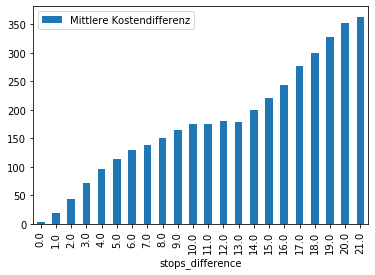

In [73]:
comparisons['Mittlere Kostendifferenz'] = comparisons['cost_difference'] * -1
comparisons.groupby(['stops_difference'])[['Mittlere Kostendifferenz']].mean().plot.bar()

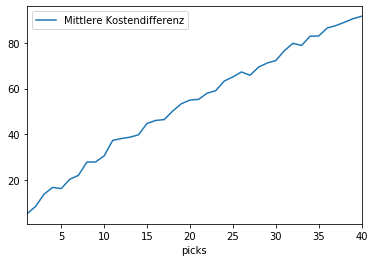

In [82]:
comparisons['Mittlere Kostendifferenz'] = comparisons['cost_difference'] * -1
comparisons['Differenz der Haltanzahl'] = comparisons['stops_difference']
comparisons.groupby(['picks'])[['Mittlere Kostendifferenz']].mean().plot()

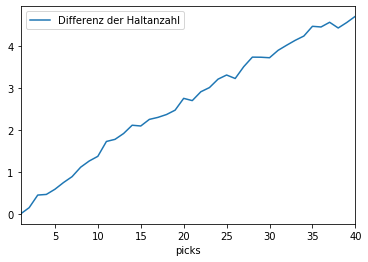

In [53]:
comparisons['Differenz der Haltanzahl'] = comparisons['stops_difference']
comparisons.groupby(['picks'])[['Differenz der Haltanzahl']].mean().plot()

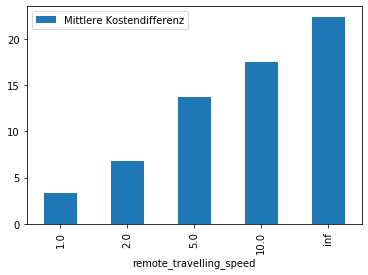

In [83]:

a = comparisons.groupby([
    'remote_travelling_speed'
])[['Mittlere Kostendifferenz']].median().plot.bar()


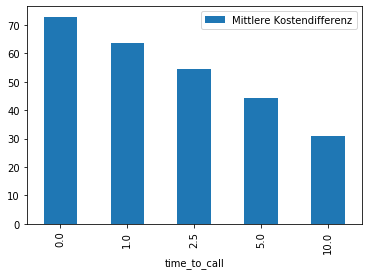

In [85]:
b = comparisons.groupby([
    'time_to_call',
])[['Mittlere Kostendifferenz']].mean().plot.bar()

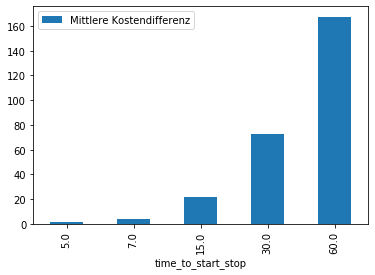

In [86]:
c = comparisons.groupby([
    'time_to_start_stop',
])[['Mittlere Kostendifferenz']].mean().plot.bar()

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
axs[0].bar(comparisons.groupby([
        'time_to_start_stop',
    ])[['Mittlere Kostendifferenz']].mean())
axs[1] = b
axs[2] = c
fig.suptitle('Categorical Plotting')

SyntaxError: invalid syntax (<ipython-input-90-e88ef7af7382>, line 5)